<a href="https://colab.research.google.com/github/ModelEarth/community/blob/master/HERON_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install SPARQLWrapper
!pip install keycloak-basic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.3 MB/s eta 0:00:00


Return all homes

In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("https://graph.openmetrics.eu/repositories/HERON")
sparql.setQuery("""
      PREFIX brick: <https://brickschema.org/schema/Brick#>
      PREFIX owl: <http://www.w3.org/2002/07/owl#>
      PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
      PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
      PREFIX ref: <https://brickschema.org/schema/Brick/ref#>
      PREFIX timeseries: <http://digibuild-project.com/timeseries#>
      SELECT ?b ?bl
      WHERE {
        ?b a brick:Building .
        ?b rdfs:label ?bl
      }
      ORDER BY ASC(?bl)
      """)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
BUILDINGS = []
for result in results["results"]["bindings"]:
  BUILDINGS.append(result["bl"]["value"])

print(BUILDINGS)

['263', '268', '272', '273', '279', '283', '284', '285', '286', '287', '39']


Retutn the equipment of home "39"

In [3]:
HOME = "39"

In [4]:
sparql = SPARQLWrapper("https://graph.openmetrics.eu/repositories/HERON")
sparql.setQuery("""
      PREFIX brick: <https://brickschema.org/schema/Brick#>
      PREFIX owl: <http://www.w3.org/2002/07/owl#>
      PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
      PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
      PREFIX ref: <https://brickschema.org/schema/Brick/ref#>
      PREFIX timeseries: <http://digibuild-project.com/timeseries#>
      SELECT ?e ?el
      WHERE {
        ?b a brick:Building .
        ?b rdfs:label ?bl .
        ?e a brick:Electrical_Equipment .
        ?e rdfs:label ?el .
        ?e brick:hasLocation ?b .
        FILTER(?bl = '""" + HOME + """')
      }
      ORDER BY ASC(?el)
      """)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
EQUIPMENT_LIST = []
for result in results["results"]["bindings"]:
  EQUIPMENT_LIST.append(result["el"]["value"])

print(EQUIPMENT_LIST)

['Boiler', 'Dishwasher', 'TV', 'Washing_Machine_Dryer']


Return the points of the selected equipment "Boiler"

In [5]:
EQUIPMENT = "Boiler"

In [6]:
from ctypes import pointer
sparql = SPARQLWrapper("https://graph.openmetrics.eu/repositories/HERON")
sparql.setQuery("""
      PREFIX brick: <https://brickschema.org/schema/Brick#>
      PREFIX owl: <http://www.w3.org/2002/07/owl#>
      PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
      PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
      PREFIX ref: <https://brickschema.org/schema/Brick/ref#>
      PREFIX timeseries: <http://digibuild-project.com/timeseries#>
      SELECT ?e ?el ?m ?p ?d_name ?t_name ?f_name ?pc ?pl
      WHERE {
        ?b a brick:Building .
        ?b rdfs:label ?bl .
        ?e a brick:Electrical_Equipment .
        ?e rdfs:label ?el .
        ?m brick:meters ?e .
        ?m a brick:Electrical_Meter .
        ?m brick:hasPoint ?p .
        ?p a ?pc .
        bind( strafter(str(?pc),"#") as ?pl) .
        ?e rdfs:label ?el .
        ?e brick:hasLocation ?b .
        ?p ref:hasTimeseriesReference ?ext .
        ?ext timeseries:database ?d_name .
        ?ext timeseries:table ?t_name .
        ?ext timeseries:id ?f_name .
        FILTER(?bl = '""" + HOME + """') .
        FILTER(?el = '""" + EQUIPMENT + """')
      }
      ORDER BY ASC(?p)
      """)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
REF_LIST = []
for result in results["results"]["bindings"]:
  ref = {}
  ref["point"] = result["pl"]["value"]
  ref["database"] = result["d_name"]["value"]
  ref["table"] = result["t_name"]["value"]
  ref["field"] = result["f_name"]["value"]
  REF_LIST.append(ref)
print(REF_LIST)


[{'point': 'Electric_Energy_Sensor', 'database': 'digibuild_db.public', 'table': 'heron_domxem3_ecfabcc7f071', 'field': 'energy_2'}, {'point': 'Electric_Energy_Sensor', 'database': 'digibuild_db.public', 'table': 'heron_domxem3_ecfabcc7f071', 'field': 'energy_1'}]


Data Sharing authentication

In [41]:
from keycloak import Keycloak, Token

keycloak: Keycloak = Keycloak(
    "http://digibuild.epu.ntua.gr/auth",                        # Keycloak server URL with no trailing path
    "DIGIBUILD",                                                # Name of realm to authenticate in
    "data_sharing",                                             # Client ID
    client_secret = "20883f27-8f3c-4826-b908-c099b5ab279e"      # Client secret, if present
)

token: Token = keycloak.auth(
    "kkatsigarakis",               # User username
    "kkatsigarakis@DIGIBUILD2023"  # User password
)

print(token.token)

eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJiOHNTdndyTmp0eUM1S0hkZnV6LTlIQ2lGSlV0YnRvRTRXNzM0dDNtdnU0In0.eyJleHAiOjE3MDQ3MjY0NzEsImlhdCI6MTcwNDcxNTY3MSwianRpIjoiY2EyNThiZTYtMzAxYi00MjZiLWFlNTUtYWRiZmFiZDdjMWU1IiwiaXNzIjoiaHR0cDovL2RpZ2lidWlsZC5lcHUubnR1YS5nci9hdXRoL3JlYWxtcy9ESUdJQlVJTEQiLCJzdWIiOiIzNDE5YjZhNC1jZWMyLTRlZTQtOGY2Ni00NWE3NmFjOWQ0NmMiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJkYXRhX3NoYXJpbmciLCJzZXNzaW9uX3N0YXRlIjoiMjlkZjI0MWYtMmE5Yi00ODJhLWI0ZTktOWI1YTY5Y2Y4NjEyIiwiYWNyIjoiMSIsInJlYWxtX2FjY2VzcyI6eyJyb2xlcyI6WyJkaWdpYnVpbGRfdXNlciJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImRhdGFfc2hhcmluZyI6eyJyb2xlcyI6WyJkYXRhX3NoYXJpbmdfdXNlciIsInVjbF9kZXZzIl19fSwic2NvcGUiOiJwcm9maWxlIGVtYWlsIiwic2lkIjoiMjlkZjI0MWYtMmE5Yi00ODJhLWI0ZTktOWI1YTY5Y2Y4NjEyIiwiZW1haWxfdmVyaWZpZWQiOmZhbHNlLCJuYW1lIjoiS3lyaWFrb3MgS2F0c2lnYXJha2lzIiwicHJlZmVycmVkX3VzZXJuYW1lIjoia2thdHNpZ2FyYWtpcyIsImdpdmVuX25hbWUiOiJLeXJpYWtvcyIsImZhbWlseV9uYW1lIjoiS2F0c2lnYXJha2lzIiwiZW1haWwiOiJrLmthdHNpZ2FyYWtpc0B1Y2wuYWMudWsifQ.aOEIANq_mfk5q

Retun time series data of the points

{'point': 'Electric_Energy_Sensor', 'field': 'energy_2', 'values': [[1704715200, 133], [1704714300, 285], [1704713400, 285], [1704712500, 285], [1704711600, 132], [1704711600, 282], [1704710700, 272], [1704709800, 270], [1704708900, 270], [1704708000, 128], [1704708000, 276], [1704707100, 283], [1704706200, 276], [1704705300, 280], [1704704400, 109], [1704704400, 274], [1704703500, 271], [1704702600, 271], [1704701700, 271], [1704700800, 108], [1704700800, 271], [1704699900, 272], [1704699000, 274], [1704698100, 273]]}
{'point': 'Electric_Energy_Sensor', 'field': 'energy_1', 'values': [[1704715200, 301], [1704714300, 576], [1704713400, 215], [1704712500, 621], [1704711600, 205], [1704711600, 547], [1704710700, 237], [1704709800, 640], [1704708900, 535], [1704708000, 141], [1704708000, 260], [1704707100, 646], [1704706200, 521], [1704705300, 273], [1704704400, 260], [1704704400, 642], [1704703500, 534], [1704702600, 267], [1704701700, 649], [1704700800, 178], [1704700800, 567], [1704699

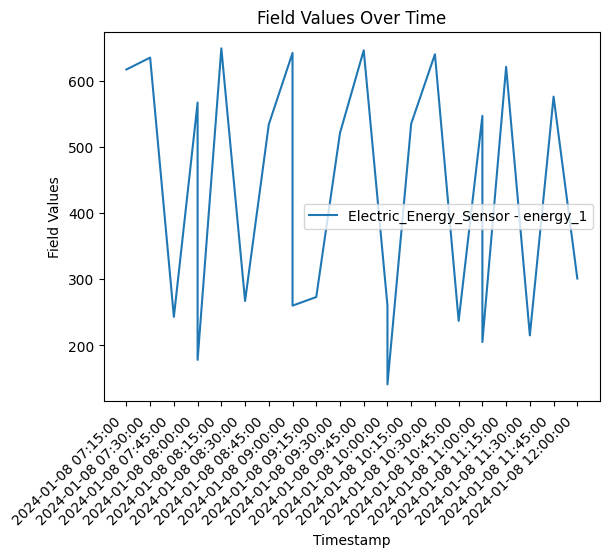

In [54]:
import requests, json
import pandas as pd
import datetime
import matplotlib.pyplot as plt

headers = {"Content-Type": "application/json; charset=utf-8","Authorization":"Bearer " + token.token}

if token.authenticated:
  for R in REF_LIST:
      body = {"query": "SELECT timestamp," + R["field"] + " FROM " + R["database"] + "." + R["table"] + " ORDER BY timestamp DESC LIMIT 24"}
      x = requests.post(url="http://digibuild.epu.ntua.gr/data_sharing/federated_querying/execute_query/", json=body, headers=headers)
      data = {}
      data["point"] = R["point"]
      data["field"] = R["field"]
      data["values"] = json.loads(x.text)
      print(data)



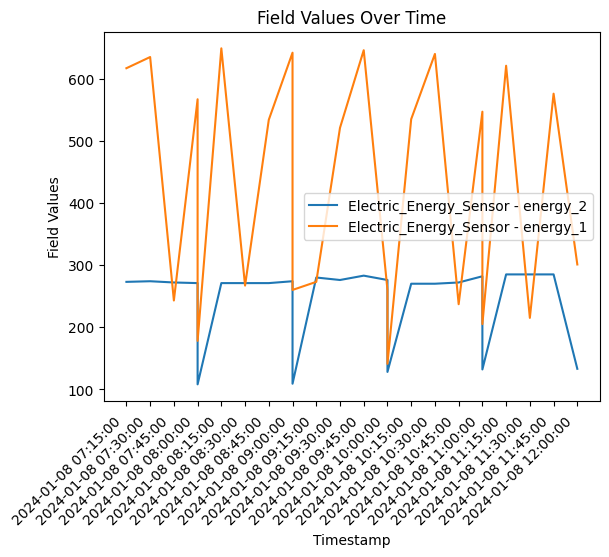

In [55]:
import requests
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt

headers = {"Content-Type": "application/json; charset=utf-8", "Authorization": "Bearer " + token.token}

# Assume you have a list of datasets
datasets = []

# Iterate through each dataset
for R in REF_LIST:
    body = {"query": "SELECT timestamp," + R["field"] + " FROM " + R["database"] + "." + R["table"] + " ORDER BY timestamp DESC LIMIT 24"}
    x = requests.post(url="http://digibuild.epu.ntua.gr/data_sharing/federated_querying/execute_query/", json=body, headers=headers)
    data = {}
    data["point"] = R["point"]
    data["field"] = R["field"]
    data["values"] = json.loads(x.text)
    datasets.append(data)

# Plotting the data for each dataset
for data in datasets:
    timestamps = []
    field_values = []

    for v in data["values"]:
        timestamps.append(datetime.datetime.fromtimestamp(v[0]).strftime('%Y-%m-%d %H:%M:%S %Z'))
        field_values.append(v[1])

    # Reverse the order of lists
    timestamps.reverse()
    field_values.reverse()

    # Plotting the data
    plt.plot(timestamps, field_values, label=data['point'] + ' - ' + data['field'])

# Adding labels and legend
plt.xlabel('Timestamp')
plt.ylabel('Field Values')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

plt.legend()
plt.title('Field Values Over Time')

# Displaying the plot
plt.show()

